<a href="https://colab.research.google.com/github/vmatiasw/modelos_y_simulacion/blob/main/P7E5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

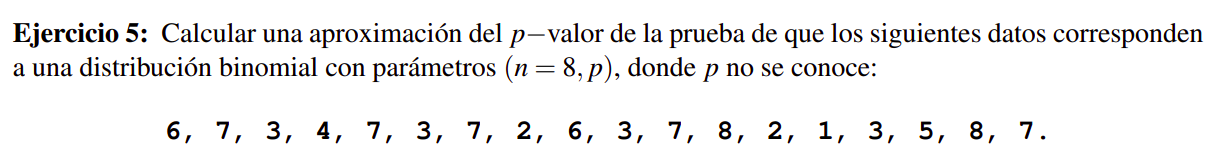

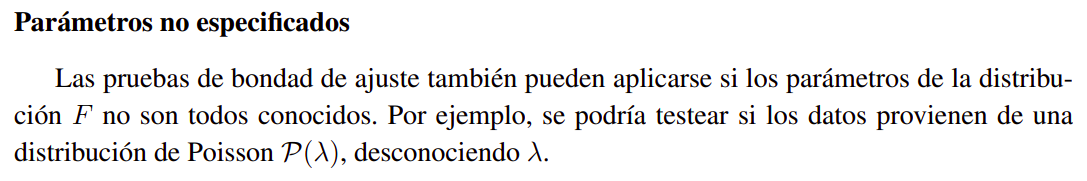

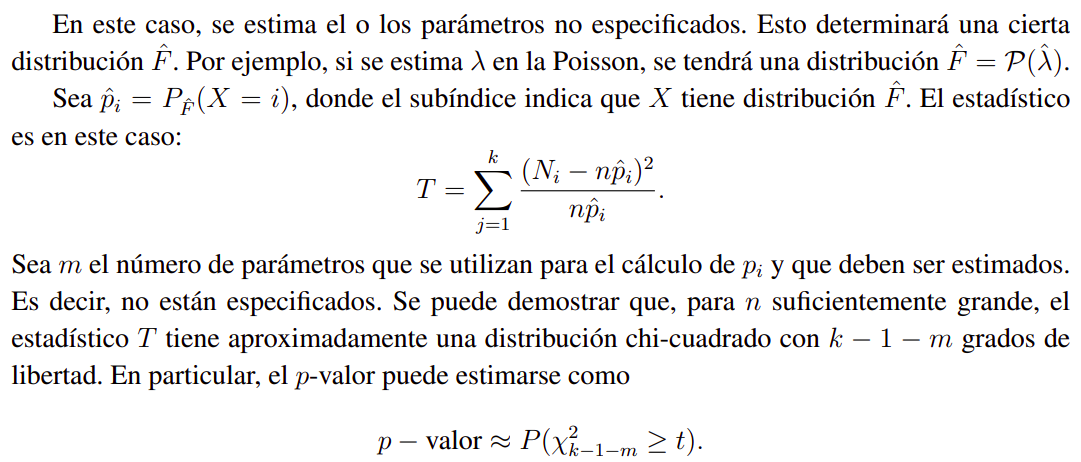

In [43]:
from scipy.stats import chi2
from random import random, seed
import numpy as np
import math

N_SIM = 100_000
MUESTRA_EMPIRICA = sorted([6, 7, 3, 4, 7, 3, 7, 2, 6, 3, 7, 8, 2, 1, 3, 5, 8, 7])
n_PARAMETRO = 8
PARAMETROS_DESCONOCIDOS = 1

# estimador P(E) = sum(muestra / n_PARAMETRO) / len(muestra)
def estimador_p(muestra):
    vmuestra = np.asarray(muestra)
    return sum(vmuestra / n_PARAMETRO) / len(vmuestra)

p_estimado = estimador_p(MUESTRA_EMPIRICA)
print(f"estimador empirico de p parametro desconocido de la binomial: {p_estimado}")

estimador empirico de p parametro desconocido de la binomial: 0.6180555555555556


In [44]:
TAMANO_MUESTRA_EMPIRICA = len(MUESTRA_EMPIRICA)
VALORES = list(range(0,9))
FRECUENCIAS_EMPIRICAS = [MUESTRA_EMPIRICA.count(valor) for valor in VALORES]

def fpm_Bin(x, p, n=n_PARAMETRO):
    return math.comb(n, x) * p**x * (1 - p)**(n - x)

PROBABILIDADES_ESPERADAS = [fpm_Bin(x, p_estimado) for x in range(n_PARAMETRO + 1)]
PROBABILIDADES_OBSERVADAS = [frecuencia_empirica / TAMANO_MUESTRA_EMPIRICA for frecuencia_empirica in FRECUENCIAS_EMPIRICAS]

# Mostrar tabla
print(f"n = {TAMANO_MUESTRA_EMPIRICA}")
print(f"{'Valor':<10} {'Prob esperada':<15} {'Prob observada':<15} {'Frec empirica':<15} {'Diferencia Probs':<15}")
print("-" * 80)
for valor, prob_esp, prob_emp, frec_emp in zip(VALORES, PROBABILIDADES_ESPERADAS, PROBABILIDADES_OBSERVADAS, FRECUENCIAS_EMPIRICAS):
    print(f"{valor:<10} {prob_esp:<15.4f} {prob_emp:<15.4f} {frec_emp:<15} {abs(prob_emp-prob_esp):<15.4f}")


n = 18
Valor      Prob esperada   Prob observada  Frec empirica   Diferencia Probs
--------------------------------------------------------------------------------
0          0.0005          0.0000          0               0.0005         
1          0.0059          0.0556          1               0.0497         
2          0.0332          0.1111          2               0.0779         
3          0.1075          0.2222          4               0.1148         
4          0.2174          0.0556          1               0.1618         
5          0.2814          0.0556          1               0.2258         
6          0.2277          0.1111          2               0.1166         
7          0.1053          0.2778          5               0.1725         
8          0.0213          0.1111          2               0.0898         


In [45]:
def estadistico_chi2(frec_empirica, prob_esperada, n):
    obs = np.asarray(frec_empirica)
    esperadas = n * np.asarray(prob_esperada)
    return sum((obs - esperadas) ** 2 / esperadas)

# Cálculo del p-valor
k_grados_libertad = len(VALORES) - 1 - PARAMETROS_DESCONOCIDOS
t_estadistico_observado = estadistico_chi2(FRECUENCIAS_EMPIRICAS, PROBABILIDADES_ESPERADAS, TAMANO_MUESTRA_EMPIRICA)
p_valor = chi2.sf(t_estadistico_observado, df=k_grados_libertad)

# Resultado final
print(f"p-valor = P(chi²_{k_grados_libertad} ≥ {t_estadistico_observado:.4f}) = {p_valor:.4f}")

p-valor = P(chi²_7 ≥ 31.4993) = 0.0001


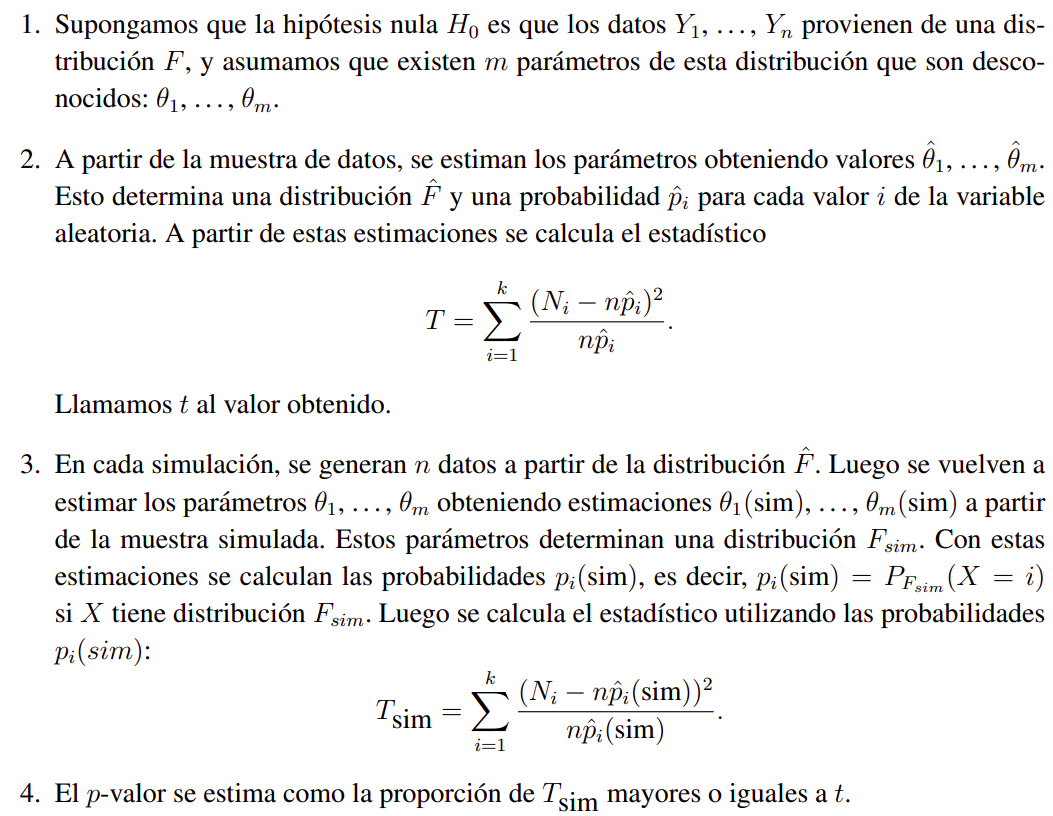

In [52]:
acumulada = np.cumsum(PROBABILIDADES_ESPERADAS)
def muestreador_F(): # F = Dist H0
    return VALORES[acumulada.searchsorted(random())]
    # u = random()
    # acc = 0
    # for valor, prob in zip(VALORES, PROBABILIDADES_ESPERADAS):
    #     acc += prob
    #     if u < acc:
    #         return valor

def estimar_Pvalor_conF(n_sim):
  cuenta = 0
  for _ in range(n_sim):
    muestra = [muestreador_F() for _ in range(TAMANO_MUESTRA_EMPIRICA)]
    frecuencias = [muestra.count(x) for x in VALORES]

    p_estimado = estimador_p(muestra)
    t_probs = [fpm_Bin(x, p_estimado) for x in range(n_PARAMETRO + 1)]

    t_muestra = estadistico_chi2(frecuencias, t_probs, TAMANO_MUESTRA_EMPIRICA)
    if t_estadistico_observado <= t_muestra:
      cuenta += 1
  return cuenta / n_sim

seed(1)
print(f"p-valor estimado = {estimar_Pvalor_conF(100_000)}")

p-valor estimado = 0.00974


In [56]:
def muestreador_binomial(n,p):
    razon_chances = p / (1 - p) # odds ratio
    prob = (1 - p) ** n # P(X=0)
    Fx = prob
    x = 0
    u = random() # U ~ Uniforme(0, 1)
    while u >= Fx:
        prob *= razon_chances * (n - x) / (x + 1)
        Fx += prob # F(x)
        x += 1
    return x

def generar_frecuencias():
    Ns = []
    anterior_Fv = 0 # F(anterior v)
    anterior_sum_Ns = 0
    for prob_v in PROBABILIDADES_ESPERADAS[:-1]:
        N_v = muestreador_binomial(TAMANO_MUESTRA_EMPIRICA - anterior_sum_Ns, prob_v / (1 - anterior_Fv))
        Ns.append(N_v)
        anterior_Fv += prob_v
        anterior_sum_Ns += N_v
    Ns.append(TAMANO_MUESTRA_EMPIRICA - anterior_sum_Ns)
    return Ns

def estimar_Pvalor_conFrec(n_sim):
  t_mayores_que_t_original = 0
  for _ in range(n_sim):
    frecuencias = generar_frecuencias()

    suma_exitos = sum(k * frec for k, frec in enumerate(frecuencias))
    total_obs = sum(frecuencias)
    p_estimado = suma_exitos / (n_PARAMETRO * total_obs)

    t_probs = [fpm_Bin(x, p_estimado) for x in range(n_PARAMETRO + 1)]

    t_muestra = estadistico_chi2(frecuencias, t_probs, TAMANO_MUESTRA_EMPIRICA)
    if t_estadistico_observado < t_muestra:
      t_mayores_que_t_original += 1
  return t_mayores_que_t_original / n_sim

seed(1)
print(f"p-valor estimado = {estimar_Pvalor_conFrec(100_000)}")

p-valor estimado = 0.00999
